In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

DATA_PROCESSED = Path("../data/processed")

orders = pd.read_csv(DATA_PROCESSED / "orders_clean.csv")
customers = pd.read_csv(DATA_PROCESSED / "customers_clean.csv")

print("Orders shape:", orders.shape)
print("Customers shape:", customers.shape)

print("\nOrders columns:", orders.columns.tolist())
print("Customers columns:", customers.columns.tolist())


Orders shape: (5000, 11)
Customers shape: (4844, 4)

Orders columns: ['order_id', 'order_date', 'customer_id', 'city', 'region', 'category', 'sub_category', 'sales', 'quantity', 'discount', 'profit']
Customers columns: ['customer_id', 'customer_name', 'city', 'region']


In [4]:
if "order_date" in orders.columns:
    orders["order_date"] = pd.to_datetime(orders["order_date"], errors="coerce")
else:
    raise ValueError("'order_date' missing from orders_clean.csv")

orders[["order_date"]].head()


,order_date
0,2024-10-19
1,2025-08-30
2,2023-11-04
3,2025-05-23
4,2025-01-19


In [5]:
needed_cols = {"customer_id", "sales", "profit", "order_id"}
missing = needed_cols - set(orders.columns)

if missing:
    raise ValueError(f"Missing required columns in orders: {missing}")

orders[["customer_id", "sales", "profit", "order_id"]].head()


,customer_id,sales,profit,order_id
0,C2093,68958.6,10525.09,10001
1,C210,33732.0,6299.66,10002
2,C3419,207603.2,19850.27,10003
3,C475,158610.0,36311.02,10004
4,C266,45033.3,9050.04,10005


In [6]:
cust_metrics = (
    orders
    .groupby("customer_id")
    .agg(
        lifetime_revenue=("sales", "sum"),
        lifetime_profit=("profit", "sum"),
        num_orders=("order_id", "nunique"),
        first_order_date=("order_date", "min"),
        last_order_date=("order_date", "max")
    )
    .reset_index()
)

cust_metrics["customer_lifetime_days"] = (
    cust_metrics["last_order_date"] - cust_metrics["first_order_date"]
).dt.days

cust_metrics.head()


,customer_id,lifetime_revenue,lifetime_profit,num_orders,first_order_date,last_order_date,customer_lifetime_days
0,C1,158876.8,23210.84,1,2023-12-31,2023-12-31,0
1,C10,14384.0,2803.41,1,2023-10-15,2023-10-15,0
2,C100,77549.4,9064.67,1,2025-03-05,2025-03-05,0
3,C1000,11985.2,2016.93,1,2024-03-17,2024-03-17,0
4,C1001,203579.4,22976.86,2,2025-05-29,2025-08-06,69


In [7]:
# What columns are even available in customers?
print("Customers columns:", customers.columns.tolist())

# Columns we *would like* to bring in if they exist
preferred_cols = ["customer_id", "customer_name", "segment", "country", "city", "region"]

# Only keep the ones that are actually present
cols_to_merge = [c for c in preferred_cols if c in customers.columns]

print("Using these customer columns in merge:", cols_to_merge)

# Make sure customer_id is there
if "customer_id" not in cols_to_merge:
    raise ValueError("'customer_id' must be present in customers for merge, but it's not.")

cust_metrics = cust_metrics.merge(
    customers[cols_to_merge],
    on="customer_id",
    how="left"
)

cust_metrics.head()


Customers columns: ['customer_id', 'customer_name', 'city', 'region']
Using these customer columns in merge: ['customer_id', 'customer_name', 'city', 'region']


,customer_id,lifetime_revenue,lifetime_profit,num_orders,first_order_date,last_order_date,customer_lifetime_days,customer_name,city,region
0,C1,158876.8,23210.84,1,2023-12-31,2023-12-31,0,Aaina Balasubramanian,Hyderabad,South
1,C10,14384.0,2803.41,1,2023-10-15,2023-10-15,0,Aaina Ganguly,Bangalore,South
2,C100,77549.4,9064.67,1,2025-03-05,2025-03-05,0,Aaryahi Das,Goa,West
3,C1000,11985.2,2016.93,1,2024-03-17,2024-03-17,0,Dharmajan Kapadia,Lucknow,North
4,C1001,203579.4,22976.86,2,2025-05-29,2025-08-06,69,Dharmajan Lal,Pune,West


In [8]:
cust_metrics["lifetime_revenue"].describe()


count      4844.000000
mean     110170.525258
std       88632.704703
min         264.100000
25%       40757.237500
50%       85848.500000
75%      160902.337500
max      650151.900000
Name: lifetime_revenue, dtype: float64

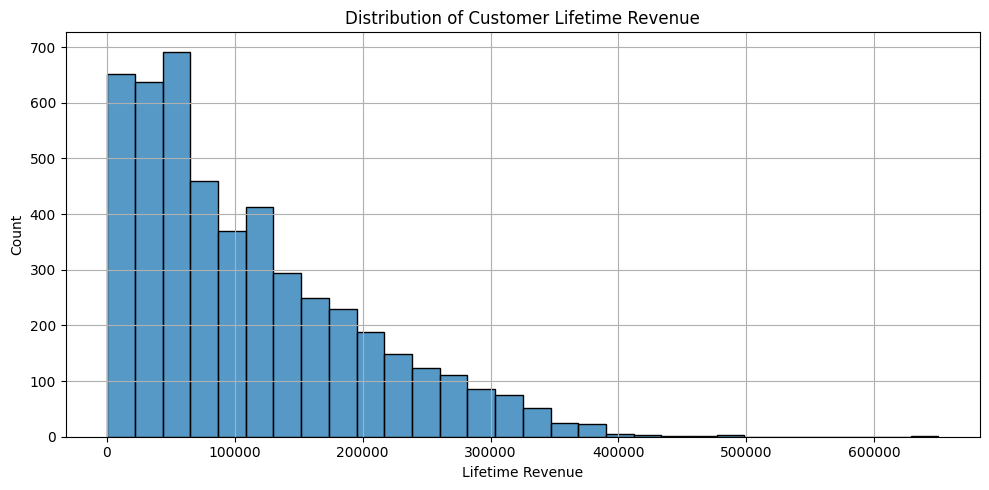

In [9]:
sns.histplot(cust_metrics["lifetime_revenue"], bins=30)
plt.title("Distribution of Customer Lifetime Revenue")
plt.xlabel("Lifetime Revenue")
plt.tight_layout()
plt.show()


In [10]:
top10 = cust_metrics.sort_values("lifetime_revenue", ascending=False).head(10)
top10[["customer_id",
       *(c for c in ["customer_name", "segment", "country"] if c in top10.columns),
       "lifetime_revenue",
       "num_orders",
       "customer_lifetime_days"]]


,customer_id,customer_name,lifetime_revenue,num_orders,customer_lifetime_days
113,C110,Aaryahi Madan,650151.9,3,204
1386,C2246,Kimaya Vala,490935.0,2,37
4521,C708,Badal Rao,485698.0,2,91
967,C187,Adira Dhingra,479389.0,2,183
3458,C4110,Sumer Mann,469937.0,2,67
1980,C2781,Nayantara Majumdar,459763.5,2,408
2382,C3142,Prerak Shere,451862.4,2,107
4569,C751,Bhamini Sane,441410.6,2,234
3062,C3755,Samarth Wagle,427715.5,2,338
4374,C576,Arhaan Basu,426563.6,2,382


In [11]:
total_rev = cust_metrics["lifetime_revenue"].sum()
top10_rev = top10["lifetime_revenue"].sum()
share = top10_rev / total_rev * 100

print(f"Top 10 customers generate {share:.2f}% of total revenue.")


Top 10 customers generate 0.90% of total revenue.


In [12]:
if "segment" in cust_metrics.columns:
    seg_rev = (
        cust_metrics
        .groupby("segment")
        .agg(
            revenue=("lifetime_revenue", "sum"),
            profit=("lifetime_profit", "sum"),
            customers=("customer_id", "nunique")
        )
        .reset_index()
        .sort_values("revenue", ascending=False)
    )

    display(seg_rev)

    sns.barplot(data=seg_rev, x="segment", y="revenue")
    plt.title("Revenue by Customer Segment")
    plt.xlabel("Segment")
    plt.ylabel("Revenue")
    plt.tight_layout()
    plt.show()
else:
    print("No 'segment' column in cust_metrics – skipping segment analysis.")


No 'segment' column in cust_metrics – skipping segment analysis.


In [13]:
if "country" in cust_metrics.columns:
    country_rev = (
        cust_metrics
        .groupby("country")
        .agg(
            revenue=("lifetime_revenue", "sum"),
            profit=("lifetime_profit", "sum"),
            customers=("customer_id", "nunique")
        )
        .reset_index()
        .sort_values("revenue", ascending=False)
    )

    display(country_rev.head(10))

    sns.barplot(data=country_rev.head(10), x="country", y="revenue")
    plt.title("Top 10 Countries by Customer Revenue")
    plt.xlabel("Country")
    plt.ylabel("Revenue")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No 'country' column in cust_metrics – skipping country breakdown.")


No 'country' column in cust_metrics – skipping country breakdown.


In [14]:
OUTPUT_PATH = DATA_PROCESSED / "customer_metrics.csv"
cust_metrics.to_csv(OUTPUT_PATH, index=False)
print(f"Saved customer metrics to {OUTPUT_PATH}")


Saved customer metrics to ..\data\processed\customer_metrics.csv
